In [14]:
import pandas as pd
data = pd.read_csv('/home/jbar/EURUSD15.csv', delimiter='\t', names='Time	Open	High	Low	Close	Volume	Spread'.split())

import numpy as np
np.set_printoptions(suppress=True)

In [15]:
data.head()

,Time,Open,High,Low,Close,Volume,Spread
0,2020-01-13 14:00,1.11187,1.11218,1.11176,1.11208,2161,NaN
1,2020-01-13 14:15,1.11211,1.11227,1.11175,1.11204,2736,NaN
2,2020-01-13 14:30,1.11205,1.11267,1.11204,1.11211,3655,NaN
3,2020-01-13 14:45,1.11211,1.11247,1.11200,1.11240,2959,NaN
4,2020-01-13 15:00,1.11239,1.11268,1.11210,1.11252,2656,NaN


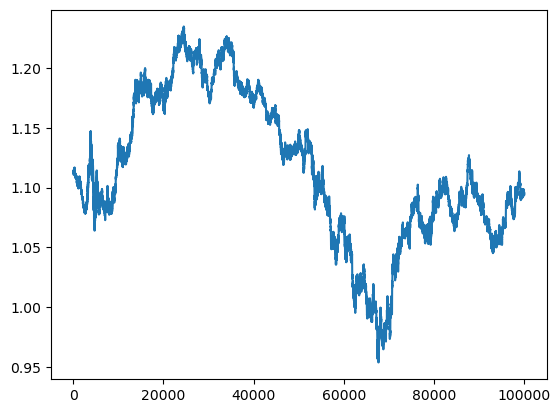

In [16]:
import matplotlib.pyplot as plt
timeseries = data['Close'].values
plt.plot(timeseries)

tensor([1.1121, 1.1120, 1.1121,  ..., 1.1287, 1.1288, 1.1290])
tensor([-3.9935e-05,  6.9976e-05,  2.9004e-04,  ..., -6.9976e-05,
         1.1992e-04,  2.0003e-04])


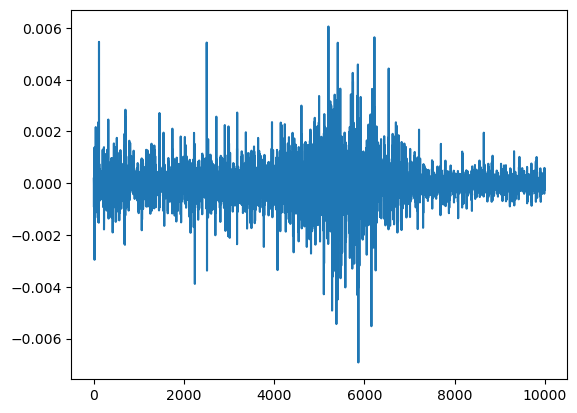

In [17]:
import torch

# Extract data

prices = torch.Tensor(data['Close'].values)[:10000]
print(prices)
print(prices.diff())
gains = prices.diff().div(prices[:-1]).flip(0)
plt.plot(gains)

tensor(1.7124e-06) tensor(0.0006)
tensor([ 0.2783,  0.1658, -0.1010,  ...,  0.4109,  0.0971, -0.0597])


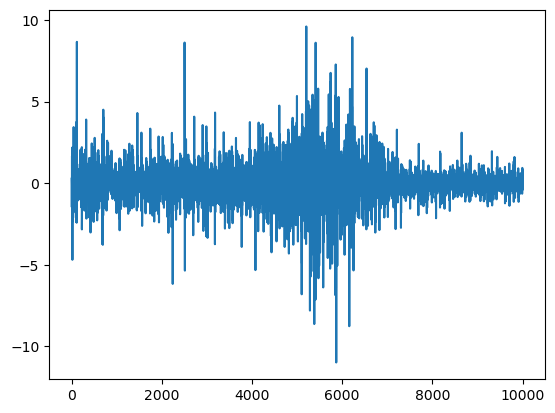

In [45]:
std, mean = torch.std_mean(gains)
print(mean, std)
gains_norm = (gains - mean) / std
print(gains_norm)
plt.plot(gains_norm[:10000])


In [19]:
# Define batches and loader

WINDOW_SIZE = 24
INPUT_SIZE = WINDOW_SIZE - 1
timeseries = gains_norm.unfold(0, WINDOW_SIZE, 1)
train_size = int(timeseries.shape[0] * 0.67)
test_size = timeseries.shape[0] - train_size
train_set, test_set = torch.utils.data.random_split(timeseries, [train_size, test_size])

# optimize this
x_train = torch.stack([sample[:INPUT_SIZE] for sample in train_set])
y_train = torch.stack([sample[INPUT_SIZE:] for sample in train_set])
x_test = torch.stack([sample[:INPUT_SIZE] for sample in test_set])
y_test = torch.stack([sample[INPUT_SIZE:] for sample in test_set])


loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=None, batch_sampler=None, shuffle=True, collate_fn=lambda sample: (sample[:INPUT_SIZE], sample[INPUT_SIZE:]))
next(iter(loader))

(tensor([-0.1778,  0.3766,  0.2307,  0.1725,  0.5082, -0.4260,  0.1725, -1.1694,
         -0.0611, -0.2214, -0.1631,  0.3910, -0.3672,  0.2890, -0.4983,  0.0847,
         -1.8376,  0.0702, -0.3667,  0.2302, -0.2648,  0.1429,  0.5507]),
 tensor([-0.5850]))

In [20]:
import torch
import torch.nn as nn

HIDDEN_SIZE = 128
class EquityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=1, batch_first=False)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [21]:
model = EquityModel()
idx = 532
model(train_set[idx].unsqueeze(0)[:INPUT_SIZE]), train_set[idx][INPUT_SIZE:]

(tensor([[0.0661]], grad_fn=<AddmmBackward0>), tensor([1.2163]))

In [22]:
prices = torch.tensor(data['Close'].values)

In [23]:
a = torch.rand(3, 1)
b = torch.rand(3, 1)
torch.Tensor(np.einsum('...i,...i->...',a,b))
b

tensor([[0.8081],
        [0.4471],
        [0.1958]])

In [57]:
import numpy as np
def money_loss(output, target):
    mov_output, mov_target = output.sum(axis=-1), target.sum(axis=-1)
    # print(mov_output, mov_target)
    exponent = - torch.sign(mov_output) * torch.sign(mov_target) * torch.abs(mov_target)
    return torch.pow(2, exponent).sum()
a, b = torch.Tensor([[1, 1]]), torch.Tensor([[-2, -8]])
money_loss(a, b)

tensor(1024.)

In [59]:
BATCH_SIZE = 6
model = EquityModel()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = money_loss

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        # print(y_pred, y_train)
        # print(y_pred.sum(), y_train.sum())
        train_rmse = loss_fn(y_pred, y_train)
        # print(train_rmse)
        y_pred = model(x_test)
        test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 11650.4736, test RMSE 4751.2246
Epoch 1: train RMSE 11650.4736, test RMSE 4751.2246
Epoch 2: train RMSE 11650.4736, test RMSE 4751.2246
Epoch 3: train RMSE 11650.4736, test RMSE 4751.2246
Epoch 4: train RMSE 11650.4736, test RMSE 4751.2246
Epoch 5: train RMSE 11650.4736, test RMSE 4751.2246
Epoch 6: train RMSE 11650.4736, test RMSE 4751.2246


KeyboardInterrupt: 